# Ion channel challenge: data cleaning and EDA

In [1]:
# Load packages
import sys
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.signal import find_peaks
from sklearn import metrics
import seaborn as sns
from pandas_profiling import ProfileReport

In [2]:
# From Eunho Lee https://www.kaggle.com/eunholee/remove-drift-using-a-sine-function

def make_batches(df, dataset="train"):
    batches = []
    batch_size = [500000, 100000]
    if dataset == "train":
        for idx in range(10):
            batches.append(df[idx * batch_size[0]: (idx + 1) * batch_size[0]])
    else:
        for idx in range(10):
            batches.append(df[idx * batch_size[1]: (idx + 1) * batch_size[1]])
        for idx in range(2):
            base = 10 * batch_size[1]
            batches.append(df[base + idx * batch_size[0]: base + (idx + 1) * batch_size[0]])
    return batches




In [3]:
def plot_all(train, test, suffix=""):
    plt.figure(figsize=(25, 5))
    plt.subplot("211")
    plt.title("Train " + suffix)
    plt.ylabel("Signal")
    plt.xticks(np.arange(0, 501, 50))
    for x in train:
        plt.plot(x['time'], x['signal'], linewidth=.1)
    plt.grid()
    plt.subplot("212")
    plt.title("Test " + suffix)
    plt.ylabel("Signal")
    plt.xticks(np.arange(500, 701, 10))
    for x in test:
        plt.plot(x['time'], x['signal'], linewidth=.1)
    plt.grid()



In [4]:
def set_param_find_peaks(df, signal, channel_array, height=None, threshold=None, distance=None, 
                         prominence=None, width=None, wlen=None, rel_height=0.5, plateau_size=None):
    # find peaks with given parameters
    x = signal
    peaks, properties = find_peaks(x, height=height, threshold=threshold, distance=distance, prominence=prominence, 
                                   width=width, wlen=wlen, rel_height=rel_height, plateau_size=plateau_size)
    plt.plot(x)
    plt.plot(peaks, x[peaks], "x")
    plt.plot(np.zeros_like(x), "--", color="gray")
    plt.show()
    print('Number of peaks found:', len(peaks))
    
    #Assess if all peaks have been found
    df['peak_detected']= pd.Index(range(0,len(df))).isin(peaks)
    df['is_channel_open'] = channel_array.astype(int) != 0
    detected = df.peak_detected.sum()
    open_channels = df.is_channel_open.sum()
    print('actual open channels:', open_channels)
    
    metrics.roc_auc_score(df['is_channel_open'], df['peak_detected'])
    conf_matr = metrics.confusion_matrix(df['is_channel_open'], df['peak_detected'])

    tn, fp, fn, tp = conf_matr.ravel()
    print('False positives:', fp) 
    print('True positives:', tp) 
    print('Precision:', np.round(100*tp /(tp+fp), 2), '%')
    print('False negatives:', fn) 
    print('True negatives:', tn) 
    print('Recall:', np.round(100*tp /(tp+fn), 2), '%')
    
    return df

In [5]:
def find_peaks_signal(df, signal, height=None, threshold=None, distance=None, prominence=None, width=None, 
               wlen=None, rel_height=0.5, plateau_size=None):
    x = signal
    peaks, properties = find_peaks(x, height=height, threshold=threshold, distance=distance, 
                                   prominence=prominence, width=width, wlen=wlen, rel_height=rel_height, 
                                   plateau_size=plateau_size)
    df['peak_detected']= 0
    df['peak_detected']= pd.Index(range(0,len(df))).isin(peaks)
    return df.head()

In [6]:
%matplotlib inline

## A. Data cleaning and pre-processing



In [7]:
# Load raw data
train = pd.read_csv('../data/raw/train.csv')
test = pd.read_csv('../data/raw/test.csv')

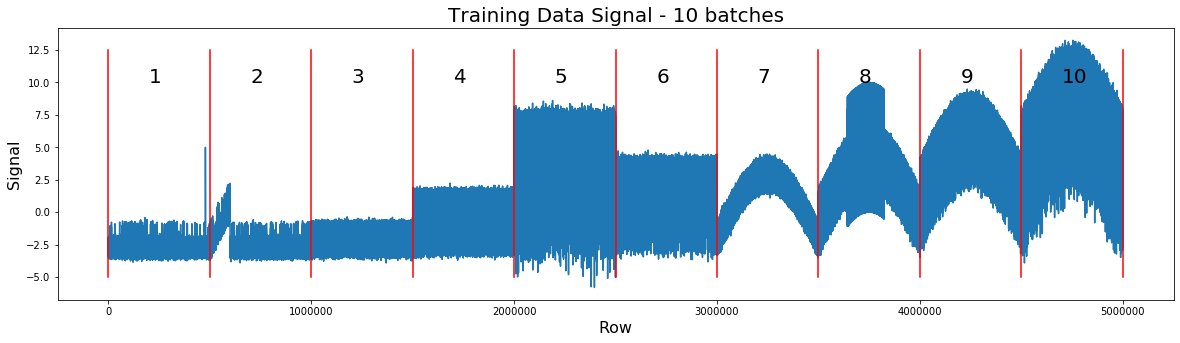

In [8]:

plt.figure(figsize=(20,5)); res = 1
plt.plot(range(0,train.shape[0],res),train.signal[0::res])
for i in range(11): plt.plot([i*500000,i*500000],[-5,12.5],'r')
for j in range(10): plt.text(j*500000+200000,10,str(j+1),size=20)
plt.xlabel('Row',size=16); plt.ylabel('Signal',size=16); 
plt.title('Training Data Signal - 10 batches',size=20)
plt.show()

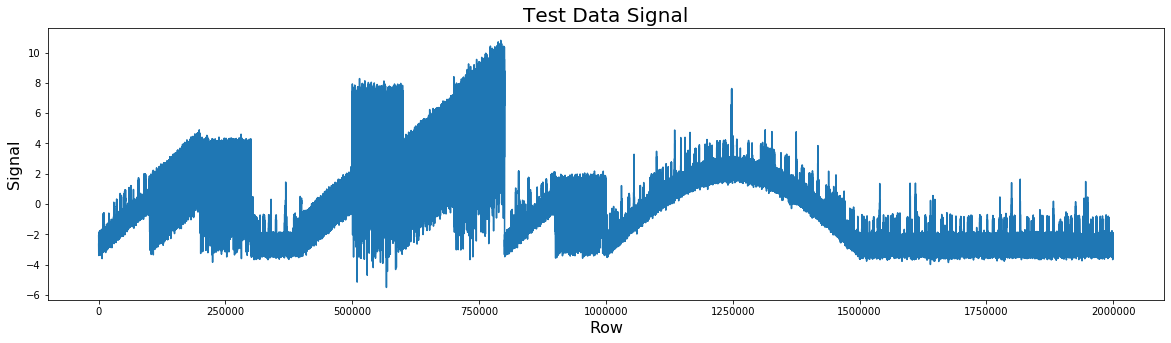

In [9]:
plt.figure(figsize=(20,5)); res = 1
plt.plot(range(0,2000000,res),test.signal[0::res])
plt.xlabel('Row',size=16); plt.ylabel('Signal',size=16); 
plt.title('Test Data Signal',size=20)
plt.show()

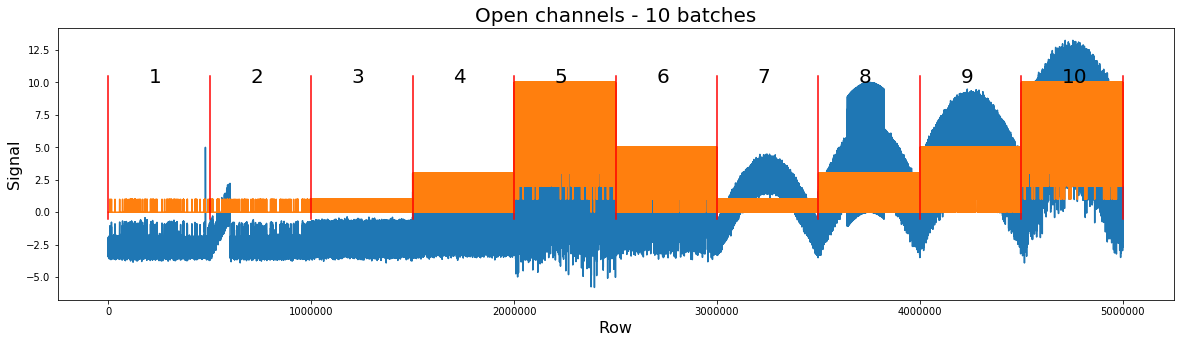

In [10]:
plt.figure(figsize=(20,5)); res = 1
plt.plot(range(0,train.shape[0],res),train.signal[0::res])
plt.plot(range(0,train.shape[0],res),train.open_channels[0::res])
for i in range(11): plt.plot([i*500000,i*500000],[-0.5,10.5],'r')
for j in range(10): plt.text(j*500000+200000,10,str(j+1),size=20)
plt.xlabel('Row',size=16); plt.ylabel('Signal',size=16); 
plt.title('Open channels - 10 batches',size=20)
plt.show()

### Remove drift

A drift has been added to the signal. A [data set](https://www.kaggle.com/cdeotte/data-without-drift) was shared by Chris Deotte. In it, he removed the drift from batches 2, 7, 8 9 and 10 (sigmoid function). This was also done on the test set.

The code below is adapted from [Euhno Lee](https://www.kaggle.com/eunholee/remove-drift-using-a-sine-function).

In [11]:
# Make batches
df_train = make_batches(train, "train")
df_test = make_batches(test, "test")

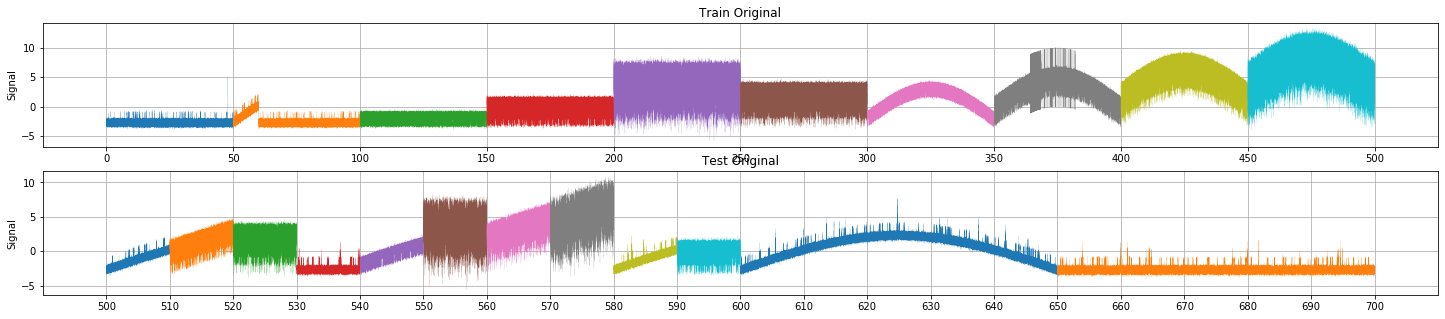

In [12]:
# Plot all
plot_all(df_train, df_test, "Original")

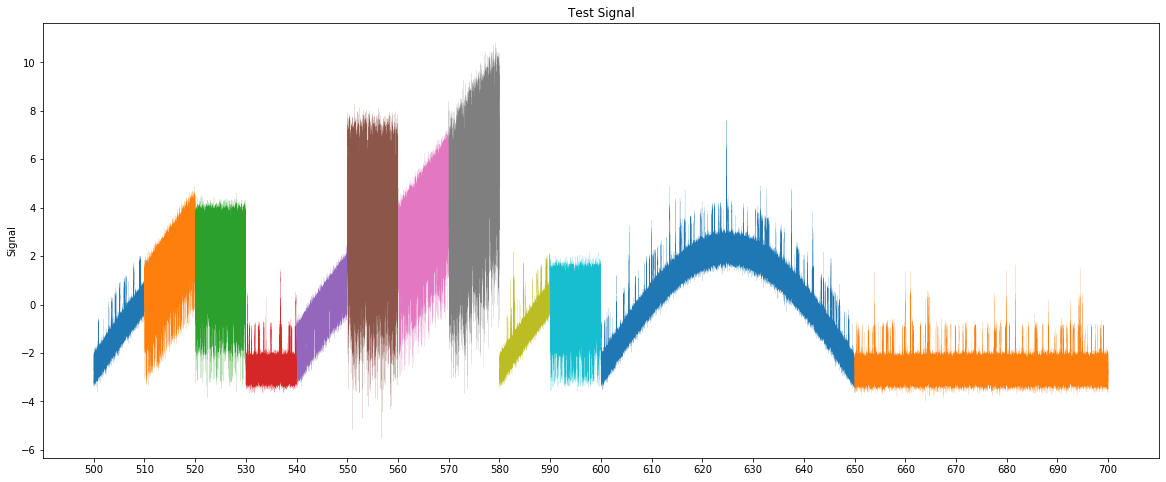

In [13]:
# Plot all
plt.figure(figsize=(20, 8))    

plt.title("Test Signal" )
plt.ylabel("Signal")
plt.xticks(np.arange(500, 701, 10))
for x in df_test:
    plt.plot(x['time'], x['signal'], linewidth=.1)
plt.show()

In [14]:
# Load data
train_c = pd.read_csv('../data/external/train_clean.csv')
test_c = pd.read_csv('../data/external/test_clean.csv')

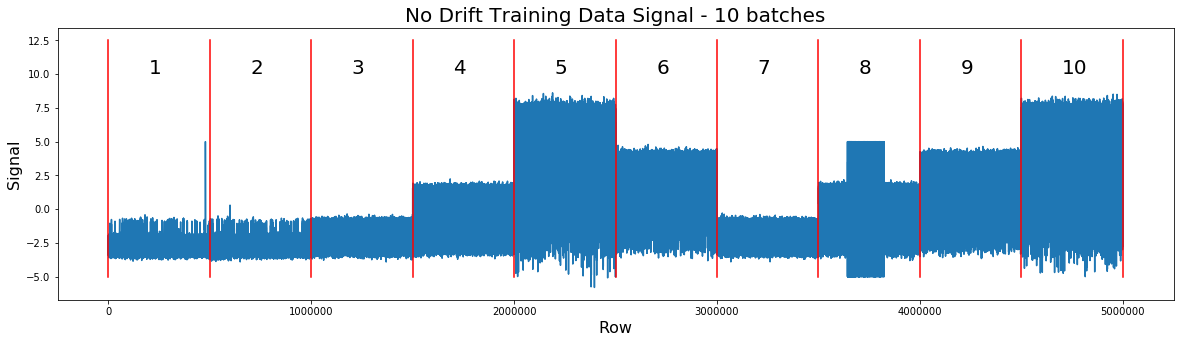

In [15]:
plt.figure(figsize=(20,5)); res = 1
plt.plot(range(0,train_c.shape[0],res),train_c.signal[0::res])
for i in range(11): plt.plot([i*500000,i*500000],[-5,12.5],'r')
for j in range(10): plt.text(j*500000+200000,10,str(j+1),size=20)
plt.xlabel('Row',size=16); plt.ylabel('Signal',size=16); 
plt.title('No Drift Training Data Signal - 10 batches',size=20)
plt.show()

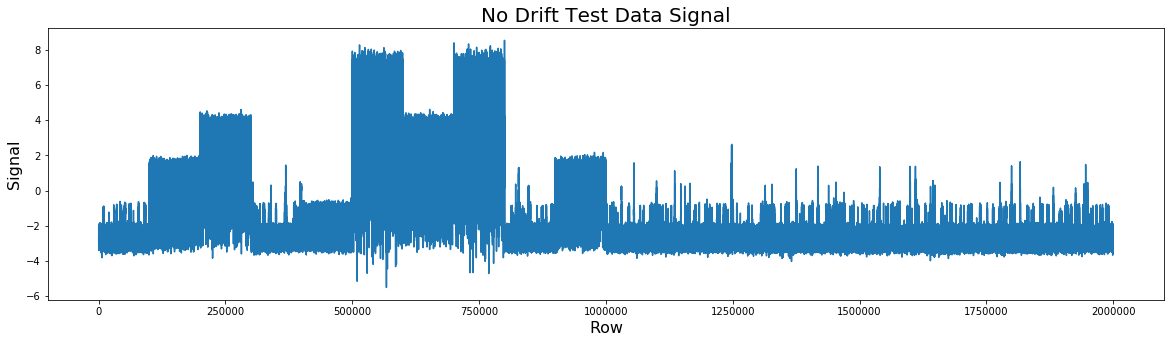

In [16]:
plt.figure(figsize=(20,5)); res = 1
plt.plot(range(0,test_c.shape[0],res),test_c.signal[0::res])

plt.xlabel('Row',size=16); plt.ylabel('Signal',size=16); 
plt.title('No Drift Test Data Signal',size=20)
plt.show()

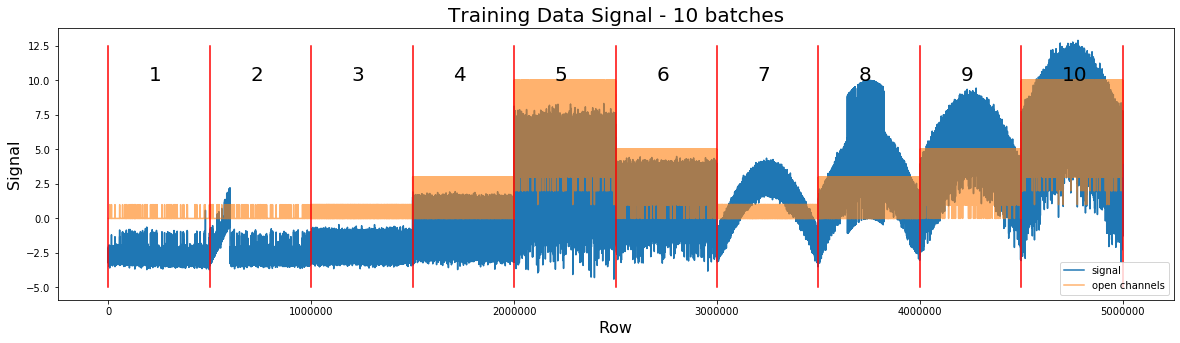

In [17]:
plt.figure(figsize=(20,5)); res = 10
plt.plot(range(0,train.shape[0],res),train.signal[0::res])
plt.plot(range(0,train.shape[0],res),train.open_channels[0::res], alpha = 0.6)
for i in range(11): plt.plot([i*500000,i*500000],[-5,12.5],'r')
for j in range(10): plt.text(j*500000+200000,10,str(j+1),size=20)
plt.legend(('signal', 'open channels'), loc='lower right')
plt.xlabel('Row',size=16); plt.ylabel('Signal',size=16); 
plt.title('Training Data Signal - 10 batches',size=20)
plt.show()

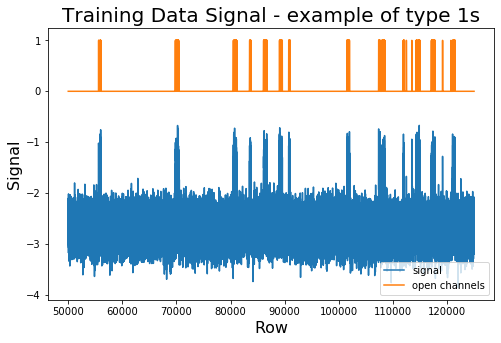

In [18]:
start = 50000
stop = 125000
plt.figure(figsize=(8,5)); res = 1
plt.plot(range(start, stop),train_c.signal[start:stop])
plt.plot(range(start, stop),train_c.open_channels[start:stop])
plt.xlabel('Row',size=16); plt.ylabel('Signal',size=16); 
plt.legend(('signal', 'open channels'), loc='lower right')
plt.title('Training Data Signal - example of type 1s',size=20)
plt.show()

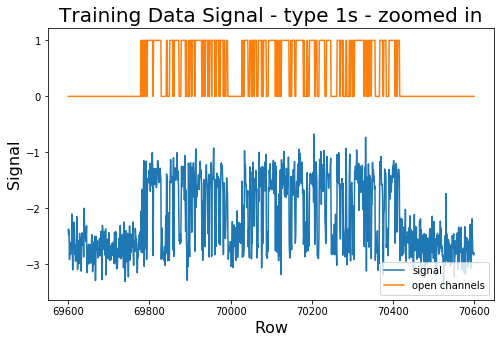

In [19]:
start = 69600
stop = 70600
plt.figure(figsize=(8,5)); res = 1
plt.plot(range(start, stop),train_c.signal[start:stop])
plt.plot(range(start, stop),train_c.open_channels[start:stop])
plt.xlabel('Row',size=16); plt.ylabel('Signal',size=16); 
plt.legend(('signal', 'open channels'), loc='lower right')
plt.title('Training Data Signal - type 1s - zoomed in',size=20)
plt.show()

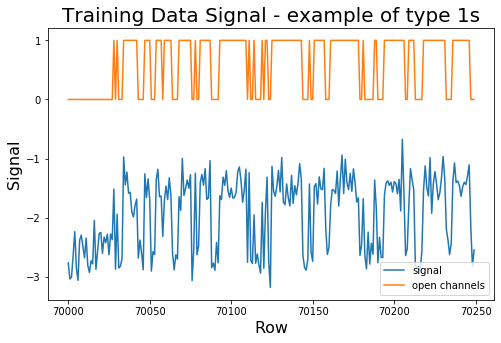

In [20]:
start = 70000
stop = 70250
plt.figure(figsize=(8,5)); res = 1
plt.plot(range(start, stop),train_c.signal[start:stop])
plt.plot(range(start, stop),train_c.open_channels[start:stop])
plt.xlabel('Row',size=16); plt.ylabel('Signal',size=16); 
plt.legend(('signal', 'open channels'))
plt.title('Training Data Signal - example of type 1s',size=20)
plt.show()

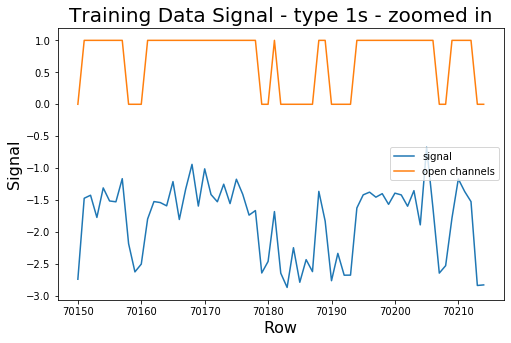

In [21]:
start = 70150
stop = 70215
plt.figure(figsize=(8,5)); res = 1
plt.plot(range(start, stop),train_c.signal[start:stop])
plt.plot(range(start, stop),train_c.open_channels[start:stop])
plt.xlabel('Row',size=16); plt.ylabel('Signal',size=16); 
plt.legend(('signal', 'open channels'))
plt.title('Training Data Signal - type 1s - zoomed in',size=20)
plt.show()

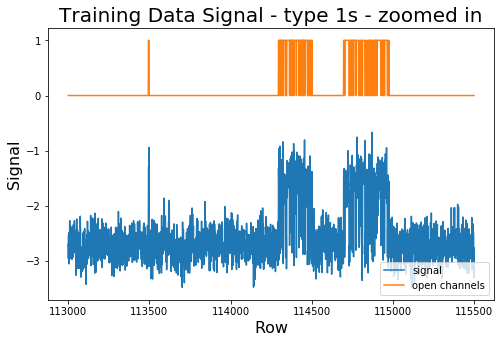

In [22]:
start = 113000
stop = 115500
plt.figure(figsize=(8,5)); res = 1
plt.plot(range(start, stop),train_c.signal[start:stop])
plt.plot(range(start, stop),train_c.open_channels[start:stop])
plt.xlabel('Row',size=16); plt.ylabel('Signal',size=16); 
plt.legend(('signal', 'open channels'), loc='lower right')
plt.title('Training Data Signal - type 1s - zoomed in',size=20)
plt.show()

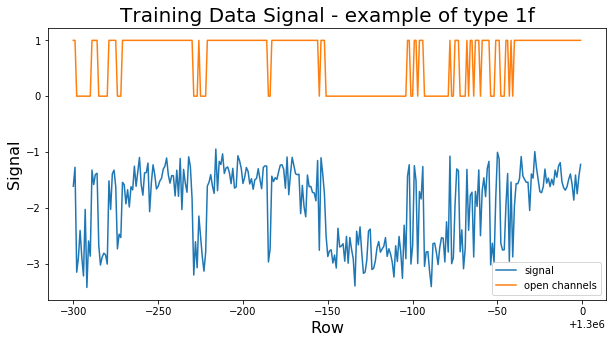

In [23]:
start = 1299700
stop = 1300000
plt.figure(figsize=(10,5)); res = 1
plt.plot(range(start, stop),train_c.signal[start:stop])
plt.plot(range(start, stop),train_c.open_channels[start:stop])
plt.xlabel('Row',size=16); plt.ylabel('Signal',size=16); 
plt.legend(('signal', 'open channels'), loc='lower right')
plt.title('Training Data Signal - example of type 1f',size=20)
plt.show()

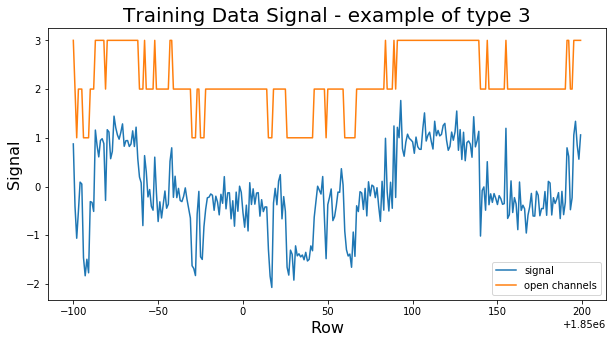

In [24]:
start = 1849900
stop = 1850200
plt.figure(figsize=(10,5)); res = 1
plt.plot(range(start, stop),train_c.signal[start:stop])
plt.plot(range(start, stop),train_c.open_channels[start:stop])
plt.xlabel('Row',size=16); plt.ylabel('Signal',size=16); 
plt.legend(('signal', 'open channels'), loc='lower right')
plt.title('Training Data Signal - example of type 3',size=20)
plt.show()

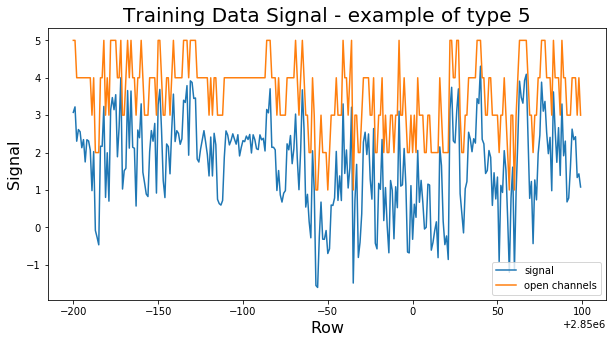

In [25]:
start = 2849800
stop = 2850100
plt.figure(figsize=(10,5)); res = 1
plt.plot(range(start, stop),train_c.signal[start:stop])
plt.plot(range(start, stop),train_c.open_channels[start:stop])
plt.xlabel('Row',size=16); plt.ylabel('Signal',size=16); 
plt.legend(('signal', 'open channels'), loc='lower right')
plt.title('Training Data Signal - example of type 5',size=20)
plt.show()

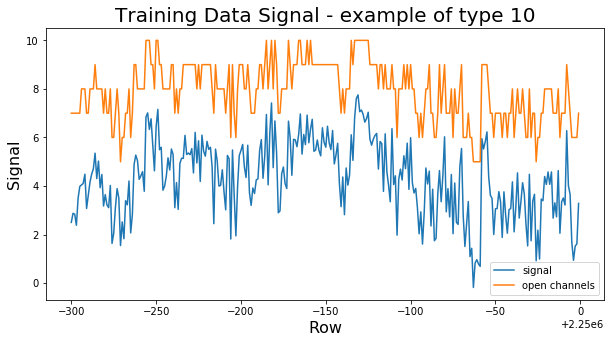

In [26]:
start = 2249700
stop = 2250000
plt.figure(figsize=(10,5)); res = 1
plt.plot(range(start, stop),train_c.signal[start:stop])
plt.plot(range(start, stop),train_c.open_channels[start:stop])
plt.xlabel('Row',size=16); plt.ylabel('Signal',size=16); 
plt.legend(('signal', 'open channels'), loc='lower right')
plt.title('Training Data Signal - example of type 10',size=20)
plt.show()

### Remove noise

Different types of filters can be applied to reduce the noise of a signal. Based on discussions related to the competition, we believe Kalman filter is more appropriate. The parameters are tested in RStudio (see report on github).

The signal with Kalman filter was downloaded from [michaln](https://www.kaggle.com/michaln/data-without-drift-with-kalman-filter)

In [27]:
# Load data
train_k = pd.read_csv('../data/external/train_kalman.csv')
test_k = pd.read_csv('../data/external/test_kalman.csv')

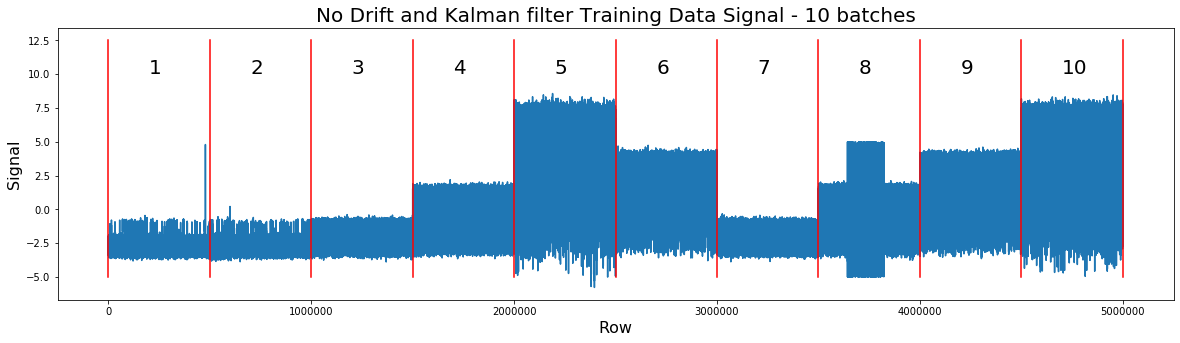

In [28]:
# Plot signal after drift is removed and Kalman filter is applied
plt.figure(figsize=(20,5)); res = 1
plt.plot(range(0,train_k.shape[0],res),train_k.signal[0::res])
for i in range(11): plt.plot([i*500000,i*500000],[-5,12.5],'r')
for j in range(10): plt.text(j*500000+200000,10,str(j+1),size=20)
plt.xlabel('Row',size=16); plt.ylabel('Signal',size=16); 
plt.title('No Drift and Kalman filter Training Data Signal - 10 batches',size=20)
plt.show()

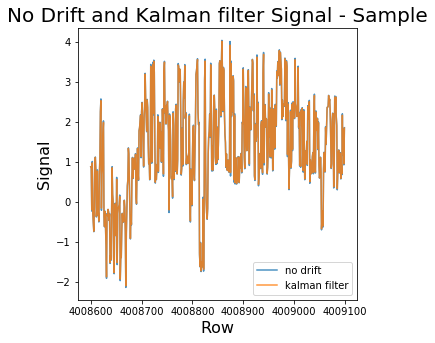

In [29]:
# Plot signal after drift is removed and Kalman filter is applied
start = 4008600
width = 4009100

plt.figure(figsize=(5,5))
plt.plot(range(start,width),train_c.signal[start:width], alpha = 0.8)
plt.plot(range(start,width),train_k.signal[start:width], alpha = 0.8)
plt.xlabel('Row',size=16); plt.ylabel('Signal',size=16); 
plt.title('No Drift and Kalman filter Signal - Sample',size=20)
plt.legend(('no drift', 'kalman filter'), loc='lower right')
plt.show()

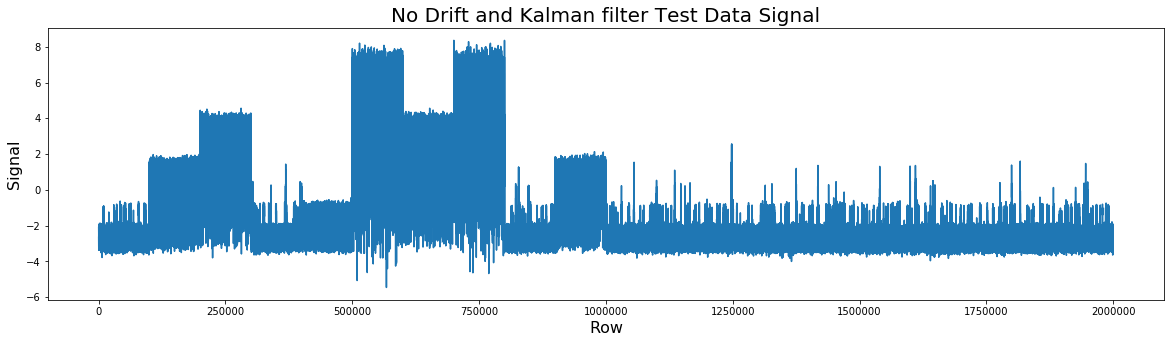

In [30]:
# Plot signal after drift is removed and Kalman filter is applied
plt.figure(figsize=(20,5)); res = 1
plt.plot(range(0,test_k.shape[0],res),test_k.signal[0::res])
#for i in range(11): plt.plot([i*500000,i*500000],[-5,12.5],'r')
#for j in range(10): plt.text(j*500000+200000,10,str(j+1),size=20)
plt.xlabel('Row',size=16); plt.ylabel('Signal',size=16); 
plt.title('No Drift and Kalman filter Test Data Signal',size=20)
plt.show()

## B. Exploratory data analysis

We want to zoom in to understand the structure of the signal around open channels (initially only on the first two batches of data).

Note that these plots don't use all the data (see resolution parameter res). 
The first three plots play with the resolution. We see peaks in the signal when a channel is open. When the resolution increases, we notice that we were missing a lot of open channels when the resolution was low.

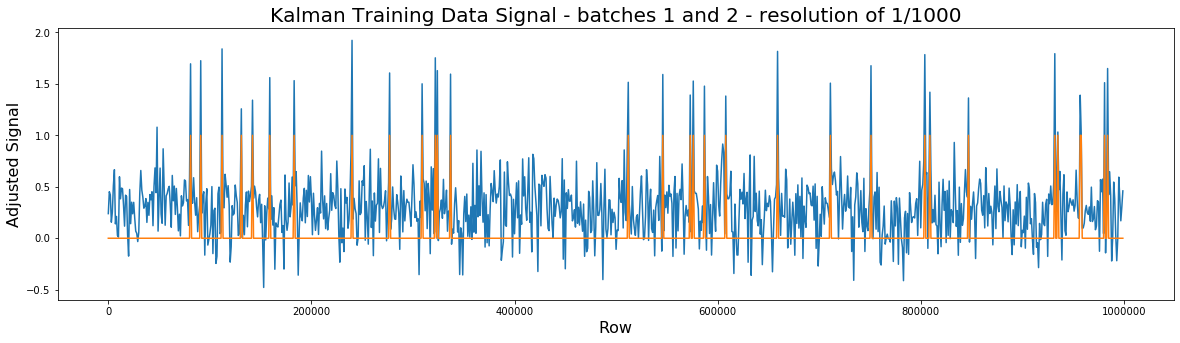

In [31]:
width = 1000000
plt.figure(figsize=(20,5)); res = 1000
plt.plot(range(0,width,res),train_k.signal[0:width:res]+3)
plt.plot(range(0,width,res),train_k.open_channels[0:width:res])
plt.xlabel('Row',size=16); plt.ylabel('Adjusted Signal',size=16); 
plt.title('Kalman Training Data Signal - batches 1 and 2 - resolution of 1/1000',size=20)
plt.show()

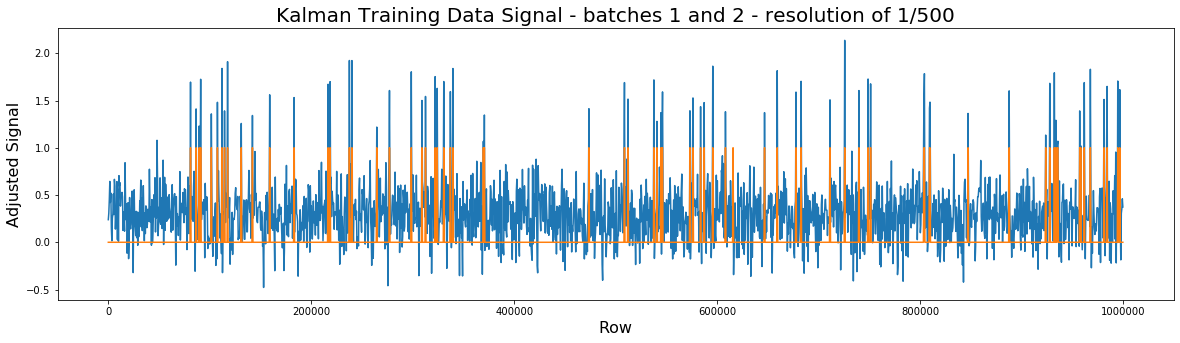

In [32]:
width = 1000000
plt.figure(figsize=(20,5)); res = 500
plt.plot(range(0,width,res),train_k.signal[0:width:res]+3)
plt.plot(range(0,width,res),train_k.open_channels[0:width:res])
plt.xlabel('Row',size=16); plt.ylabel('Adjusted Signal',size=16); 
plt.title('Kalman Training Data Signal - batches 1 and 2 - resolution of 1/500',size=20)
plt.show()

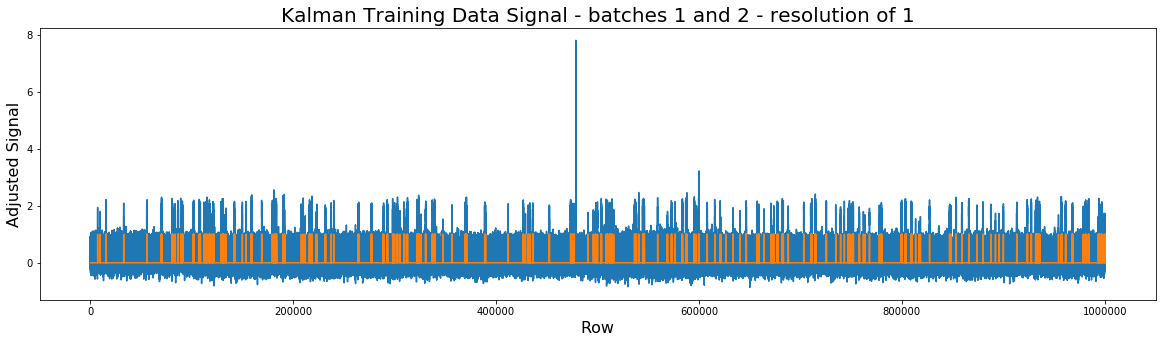

In [33]:
width = 1000000
plt.figure(figsize=(20,5)); res = 1
plt.plot(range(0,width,res),train_k.signal[0:width:res]+3)
plt.plot(range(0,width,res),train_k.open_channels[0:width:res])

#for i in range(11): plt.plot([i*500000,i*500000],[-5,12.5],'r')
#for j in range(10): plt.text(j*500000+200000,10,str(j+1),size=20)
plt.xlabel('Row',size=16); plt.ylabel('Adjusted Signal',size=16); 
plt.title('Kalman Training Data Signal - batches 1 and 2 - resolution of 1',size=20)
plt.show()

If we zoom in really close we see a peak in the signal when a channel is open. This is also true for more than one open channel.

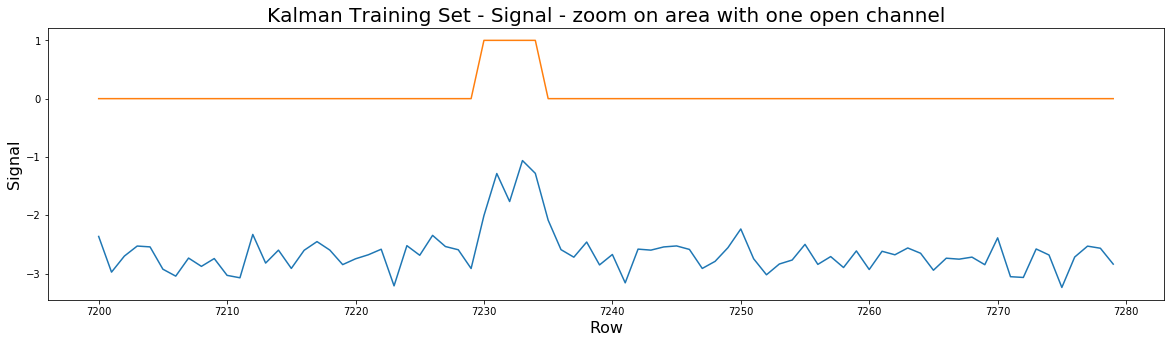

In [34]:
start = 7200
width = 7280

plt.figure(figsize=(20,5))
plt.plot(range(start,width),train_k.signal[start:width])
plt.plot(range(start,width),train_k.open_channels[start:width])
plt.xlabel('Row',size=16); plt.ylabel('Signal',size=16); 
plt.title('Kalman Training Set - Signal - zoom on area with one open channel',size=20)
plt.show()

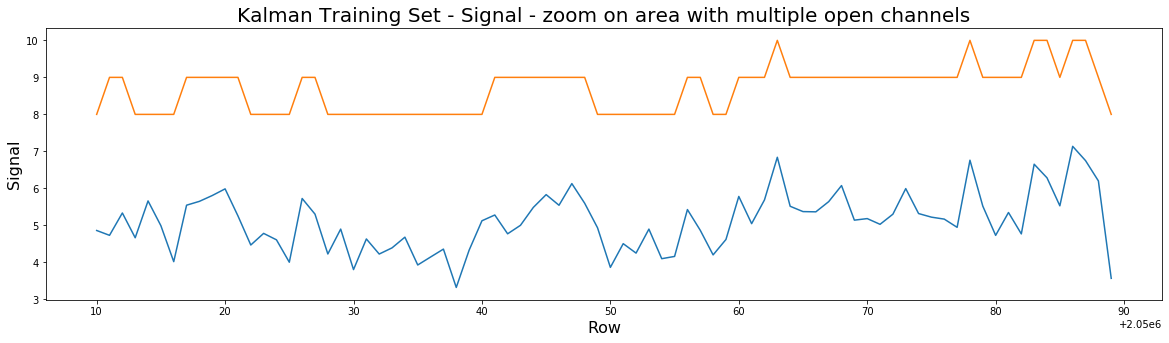

In [35]:
start = 2050010
width = 2050090

plt.figure(figsize=(20,5))
plt.plot(range(start,width),train_k.signal[start:width])
plt.plot(range(start,width),train_k.open_channels[start:width])

#for i in range(11): plt.plot([i*500000,i*500000],[-5,12.5],'r')
#for j in range(10): plt.text(j*500000+200000,10,str(j+1),size=20)
plt.xlabel('Row',size=16); plt.ylabel('Signal',size=16); 
plt.title('Kalman Training Set - Signal - zoom on area with multiple open channels',size=20)
plt.show()

### 1. EDA of the distribution of open channels

First we look at the distribution of observations between the 11 possible states (0 to 10 open channels). We look at it in percent. 

In [36]:
# Percent of timesteps in each configuration
percent_timesteps_config = train.groupby('open_channels').count().signal/50000
percent_timesteps_config

open_channels
0     24.80304
1     19.71730
2     11.07848
3     13.37218
4      8.06820
5      5.55754
6      3.76224
7      5.30030
8      4.90366
9      2.72240
10     0.71466
Name: signal, dtype: float64

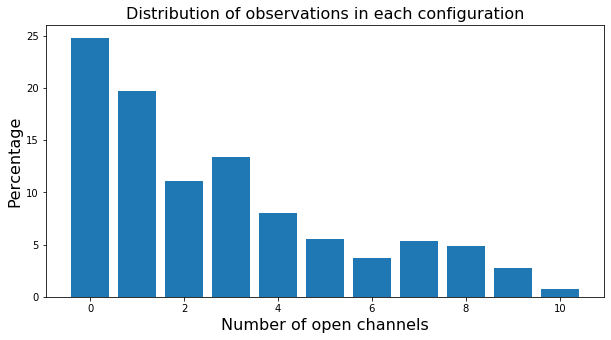

In [37]:
plt.figure(figsize=(10,5))
plt.bar(x = range(0,11), height = percent_timesteps_config)
plt.title('Distribution of observations in each configuration',size=16)
plt.xlabel('Number of open channels',size=16); plt.ylabel('Percentage',size=16); 

### 2. Lengths of the intervals
Some channels open for just one time step, some for much longer. We are trying to find the distribution of number of timesteps per opening , which we will call interval length.

We have to find the lower and upper index for each interval, then make an array of the difference between the two (which gives us the interval length). To find the indices, we make one array per configuration (number of open channel) containing the indices of all the observations in that configuration. We then make the difference with the previous index. If it's 1, the interval is on going. If it is more than 1, there was change in configuration at that timestep.

In [38]:
# Get the indexes for each level of open_channel
# WOuld have been faster with 'groupby' but I was testing multiple approaches
idx_open_channels = []
for opened in range(0, 11):
    indices = train[train.open_channels == opened].index
    idx_open_channels.append(indices)
# Sanity check
idx_open_channels[1][0:20]

Int64Index([ 7230,  7231,  7232,  7233,  7234,  9783,  9784,  9785,  9786,
             9787, 15304, 15305, 15308, 15312, 15313, 15314, 15315, 15316,
            15317, 15318],
           dtype='int64')

In [39]:
# Calculate the difference with the previous index. 
# If not 1, then there has been a change in the number of open channels
difference_idx = []
for opened in range(0, 11):
    difference = np.diff(idx_open_channels[opened])
    difference_idx.append(difference)
# Sanity check
difference_idx[1][0:20]

array([   1,    1,    1,    1, 2549,    1,    1,    1,    1, 5517,    1,
          3,    4,    1,    1,    1,    1,    1,    1,    1], dtype=int64)

In [40]:
# For each event (opening/closing), find the limits, aka the start and stop indexes
low_limit = []
up_limit = []
for opened in range(0, 11):
    temp_low = []
    temp_up = []
    temp_low.append(idx_open_channels[opened][0]) #the first index is the first lower limit for an event
    for index in range(0, len(difference_idx[opened])):
        
        if difference_idx[opened][index] > 1:
            temp_up.append(idx_open_channels[opened][index])
            temp_low.append(idx_open_channels[opened][index+1])
    temp_low.pop() # index+1 does not make sense when we reach the last event
    low_limit.append(temp_low)
    up_limit.append(temp_up)
# Sanity check
print(low_limit[1][0:20])
print(up_limit[1][0:20])

[7230, 9783, 15304, 15308, 15312, 15324, 15332, 15338, 15340, 15344, 15350, 15356, 15360, 15364, 15369, 15380, 15383, 15407, 15484, 15489]
[7234, 9787, 15305, 15308, 15322, 15328, 15333, 15338, 15341, 15347, 15354, 15356, 15362, 15367, 15376, 15380, 15399, 15410, 15486, 15497]


In [41]:
# The difference between the lower and upper limits give us the number of timesteps 
# in each interval (length of interval in timesteps)
length_open = []
for opened in range(0, 11):
    difference = np.subtract(up_limit[opened],low_limit[opened])+1
    length_open.append(difference)
    
length_open[1][0:20]

array([ 5,  5,  2,  1, 11,  5,  2,  1,  2,  4,  5,  1,  3,  4,  8,  1, 17,
        4,  3,  9], dtype=int64)

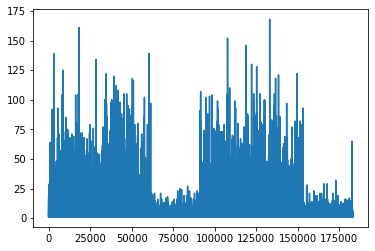

In [42]:
# Check how the distribution looks like for 2 open channels
plt.plot(length_open[2])
plt.show()

(array([6.6517e+04, 3.9000e+01, 2.6000e+01, 1.6000e+01, 8.0000e+00,
        6.0000e+00, 4.0000e+00, 3.0000e+00, 4.0000e+00, 3.0000e+00]),
 array([1.00000e+00, 2.40330e+03, 4.80560e+03, 7.20790e+03, 9.61020e+03,
        1.20125e+04, 1.44148e+04, 1.68171e+04, 1.92194e+04, 2.16217e+04,
        2.40240e+04]),
 <a list of 10 Patch objects>)

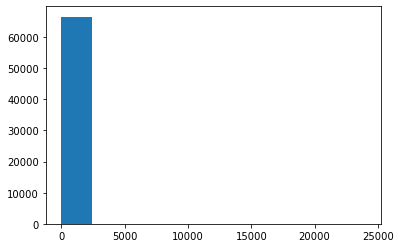

In [43]:
# better way to gauge the distribution: a histogram
plt.hist((length_open[0]))

(array([1.53575e+05, 1.85720e+04, 6.72400e+03, 1.62100e+03, 7.46000e+02,
        4.80000e+02, 2.12000e+02, 1.89000e+02, 2.02000e+02, 1.06000e+02,
        1.11000e+02, 1.09000e+02, 7.20000e+01, 5.70000e+01, 7.10000e+01,
        3.30000e+01, 4.10000e+01, 2.90000e+01, 2.40000e+01, 2.00000e+01,
        2.00000e+01, 1.80000e+01, 1.30000e+01, 1.80000e+01, 9.00000e+00,
        1.00000e+01, 6.00000e+00, 9.00000e+00, 7.00000e+00, 9.00000e+00,
        6.00000e+00, 8.00000e+00, 2.00000e+00, 1.00000e+00, 1.00000e+00,
        4.00000e+00, 2.00000e+00, 1.00000e+00, 2.00000e+00, 1.00000e+00,
        0.00000e+00, 2.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([  1.  ,   4.34,   7.68,  11.02,  14.36,  17.7 ,  21.04,  24.38,
         27.72,  31.06,  34.4 ,  37.74,  41.08,  44.42,  47.76,  51.1 ,
         54.44,  57.78,  61.12,  64.46,  67.8 ,  71.14,  74.48,  77.82,
         81.16,  84.5 ,  87.84,  91.18,  94.52,  97.

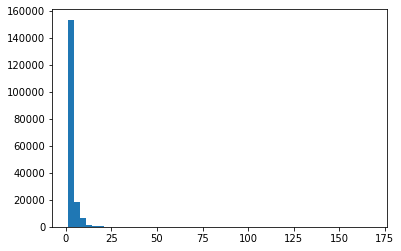

In [44]:
# For 2 open channels
plt.hist(length_open[2], bins = 50)

So many intervals are short but there are a few outliers, which throws the scale off. We are looking for a better way to display very skewed data.

In [45]:
# Make a DF with the 11 arrays 
length_df = pd.DataFrame(length_open).transpose()
length_df.describe()

,0,1,2,3,4,5,6,7,8,9,10
count,66626.000000,133244.000000,183147.000000,207870.000000,157010.000000,120620.000000,113144.000000,150272.000000,133275.000000,72645.000000,18800.000000
mean,18.613604,7.398937,3.024472,3.216467,2.569320,2.303731,1.662572,1.763555,1.839670,1.873742,1.900638
std,381.675927,43.735438,4.608297,7.525049,3.207131,4.143692,1.101263,1.255947,1.437056,1.698577,3.235515
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,5.000000,4.000000,3.000000,3.000000,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
max,24024.000000,2596.000000,168.000000,685.000000,101.000000,350.000000,19.000000,32.000000,67.000000,45.000000,263.000000


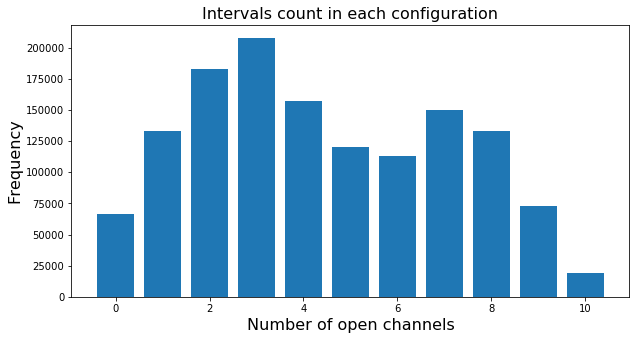

In [46]:
plt.figure(figsize=(10,5))
plt.bar(x = range(0,11), height = length_df.count())
plt.title('Intervals count in each configuration',size=16)
plt.xlabel('Number of open channels',size=16); plt.ylabel('Frequency',size=16); 
#plt.legend(('signal', 'open channels'), loc='lower right')

We are trying to gauge the distribution of the interval lengths. For example, '3 open channels' has the highestr interval count, but a lower timestep count than '0 open channels', which indicates that the intervals in configuration 0 are on average longer.

We use summary statistics but also boxplots to understand the interval lengths.

In [47]:
# The summary statistics of the interval df are a good complement to the boxplot.
length_df.describe()

,0,1,2,3,4,5,6,7,8,9,10
count,66626.000000,133244.000000,183147.000000,207870.000000,157010.000000,120620.000000,113144.000000,150272.000000,133275.000000,72645.000000,18800.000000
mean,18.613604,7.398937,3.024472,3.216467,2.569320,2.303731,1.662572,1.763555,1.839670,1.873742,1.900638
std,381.675927,43.735438,4.608297,7.525049,3.207131,4.143692,1.101263,1.255947,1.437056,1.698577,3.235515
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,5.000000,4.000000,3.000000,3.000000,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
max,24024.000000,2596.000000,168.000000,685.000000,101.000000,350.000000,19.000000,32.000000,67.000000,45.000000,263.000000


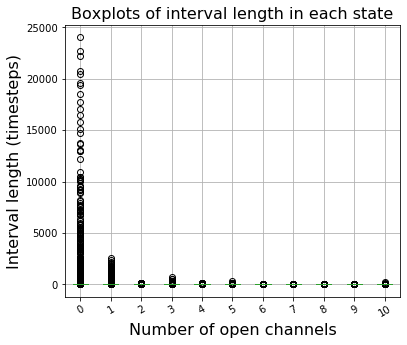

In [48]:
# Full size boxplot - the outliers are making it hard to read
plt.figure(figsize=(6,5))
ax = length_df.boxplot()
plt.setp(ax.xaxis.get_ticklabels(),rotation=30)
plt.title('Boxplots of interval length in each state' ,size=16)
plt.xlabel('Number of open channels',size=16); plt.ylabel('Interval length (timesteps)',size=16);  
plt.show()
plt.close()

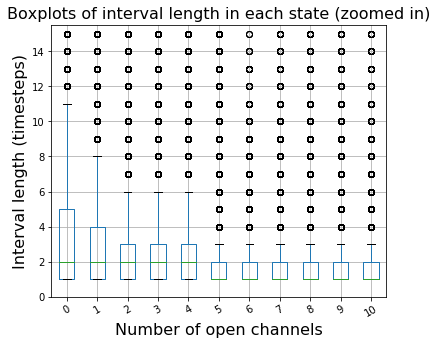

In [49]:
# Zoomed in boxplot - the outliers are missing
plt.figure(figsize=(6,5))
ax = length_df.boxplot()
plt.setp(ax.xaxis.get_ticklabels(),rotation=30)
plt.ylim((0,15.5))
plt.title('Boxplots of interval length in each state (zoomed in)' ,size=16)
plt.xlabel('Number of open channels',size=16); plt.ylabel('Interval length (timesteps)',size=16); 
plt.show()
plt.close()

We try different visualizations to see the interval lengths both for short intervals and longer (outlier) intervals

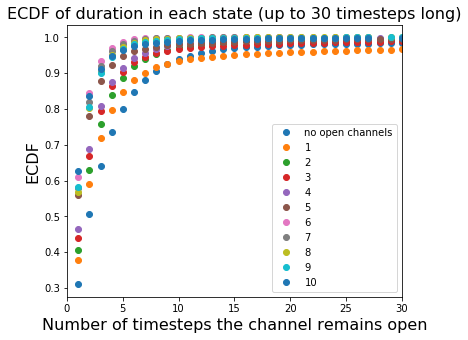

In [50]:
# ECDF
axis_limit_low = 0
axis_limit_up = 30
plt.figure(figsize=(6,5))


for opened in range(0, 11):
    cum_count = 0
    unique_elements, counts_elements = np.unique(length_open[opened], return_counts=True)
    cum_count = np.cumsum(counts_elements)
    plt.plot(unique_elements, cum_count/cum_count[-1], marker = 'o', linestyle = '')
plt.title('ECDF of duration in each state (up to 30 timesteps long)' ,size=16)
plt.xlim((axis_limit_low,axis_limit_up))
plt.xlabel('Number of timesteps the channel remains open',size=16); plt.ylabel('ECDF',size=16);  

plt.legend(['no open channels', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])

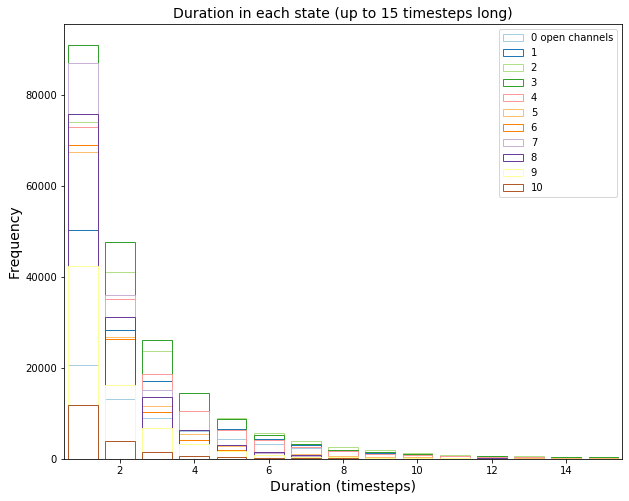

In [51]:
import matplotlib.cm as cm

axis_limit_low = 0.5
axis_limit_up = 15.5
color = cm.Paired(np.linspace(0, 1, 11))
plt.figure(figsize=(10,8))

for opened in range(0, 11):
    unique_elements, counts_elements = np.unique(length_open[opened], return_counts=True)
    plt.bar(x = unique_elements, height = counts_elements, color='None', edgecolor=color[opened], linewidth =1)
plt.title('Duration in each state (up to 15 timesteps long)' ,size=14)
plt.xlim((axis_limit_low,axis_limit_up))
plt.xlabel('Duration (timesteps)',size=14); plt.ylabel('Frequency',size=14); 

plt.legend(['0 open channels', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])

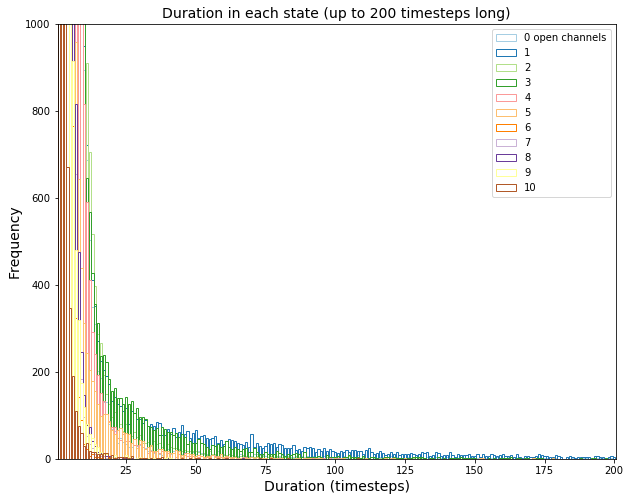

In [52]:
import matplotlib.cm as cm

axis_limit_low = 0.5
axis_limit_up = 200.5
color = cm.Paired(np.linspace(0, 1, 11))
plt.figure(figsize=(10,8))

for opened in range(0, 11):
    unique_elements, counts_elements = np.unique(length_open[opened], return_counts=True)
    plt.bar(x = unique_elements, height = counts_elements, color='None', edgecolor=color[opened], linewidth =1)
plt.title('Duration in each state (up to 200 timesteps long)' ,size=14)
plt.xlim((axis_limit_low,axis_limit_up))
plt.xlabel('Duration (timesteps)',size=14); plt.ylabel('Frequency',size=14); 
plt.ylim((0,1000))

plt.legend(['0 open channels', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])

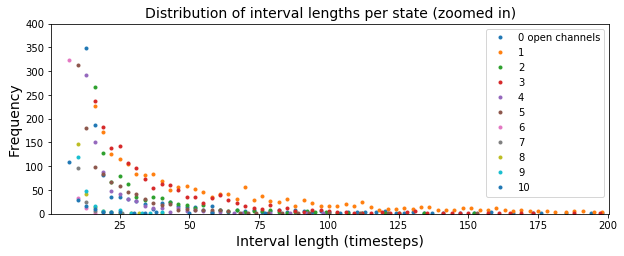

In [53]:
import matplotlib.cm as cm

axis_limit_low = 0.5
axis_limit_up = 200.5
res=3
color = cm.Paired(np.linspace(0, 1, 11))
plt.figure(figsize=(10,3.5))

for opened in range(0, 11):
    unique_elements, counts_elements = np.unique(length_open[opened], return_counts=True)
    plt.plot(unique_elements[::res], counts_elements[::res], linewidth =0, marker = '.')
plt.title('Distribution of interval lengths per state (zoomed in)' ,size=14)
plt.xlim((axis_limit_low,axis_limit_up))
plt.xlabel('Interval length (timesteps)',size=14); plt.ylabel('Frequency',size=14); 
plt.ylim((0,400))

plt.legend(['0 open channels', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])

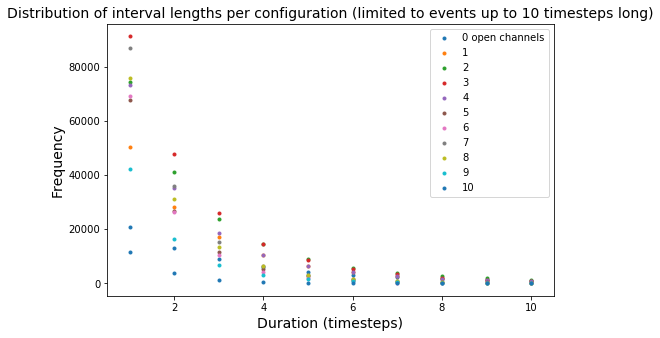

In [54]:
import matplotlib.cm as cm

axis_limit_low = 0.5
axis_limit_up = 10.5
color = cm.Paired(np.linspace(0, 1, 11))
plt.figure(figsize=(8,5))

for opened in range(0, 11):
    unique_elements, counts_elements = np.unique(length_open[opened], return_counts=True)
    plt.plot(unique_elements, counts_elements, linewidth =0, marker = '.')
plt.title('Distribution of interval lengths per configuration (limited to events up to 10 timesteps long)' ,size=14)
plt.xlim((axis_limit_low,axis_limit_up))
plt.xlabel('Duration (timesteps)',size=14); plt.ylabel('Frequency',size=14); 
#plt.ylim((0,200))

plt.legend(['0 open channels', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])

In [55]:
profile = ProfileReport(length_df)
profile

C:\Users\beren\anaconda3\envs\TensorFlow-GPU\lib\site-packages\pandas_profiling\describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,11
Number of observations,207870
Total Missing (%),40.7%
Total size in memory,17.4 MiB
Average record size in memory,88.0 B
Numeric,11
Categorical,0
Boolean,0
Date,0
Text (Unique),0
Rejected,0


The distributions are very skewed. We try a few more plots but they only capture one configuration.

In [56]:
unique_elements, counts_elements = np.unique(length_open[1], return_counts=True)

In [57]:
test = list(zip(unique_elements, counts_elements))

Text(0.5, 1.0, 'Distribution of one open channel events duration (limited to first 1000 events)')

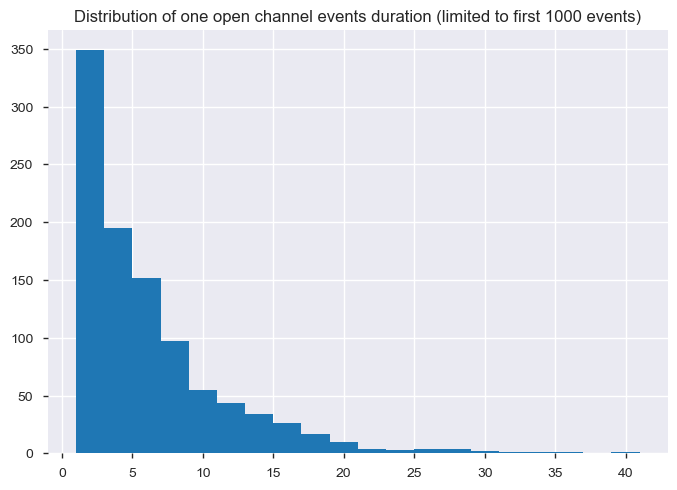

In [58]:
plt.hist(length_open[1][0:1000], bins = 20)
plt.title('Distribution of one open channel events duration (limited to first 1000 events)')

Text(0.5, 1.0, 'Distribution of one open channel events duration (limited to events up to 100 timesteps long)')

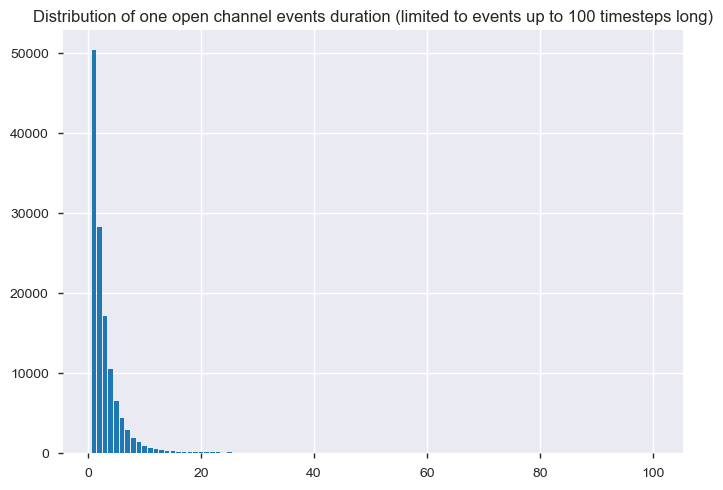

In [59]:
axis_limit_low = 0
axis_limit_up = 100
plt.bar(x = unique_elements[axis_limit_low:axis_limit_up], height = counts_elements[axis_limit_low:axis_limit_up])
plt.title('Distribution of one open channel events duration (limited to events up to 100 timesteps long)')

### 3. Long intervals prominence

We take a closer look at the distribution of events for one single open channel. We want to see how the signal behaves for one long interval, and generally analyse the impact of long intervals. 
This is important to investigate, because if our model fails at recognizing the longer events, our score would be very low due to the high number of timesteps that would get a wrong prediction.

In [60]:
# Create a DF for one open channel and sort by interval length (display the 5 longest)
open_channel_1 = pd.DataFrame([length_open[1], low_limit[1], up_limit[1]]).transpose()
open_channel_1.rename(columns={0: "length", 1: "start", 2: "stop"}, inplace = True)
open_channel_1.sort_values(by=['length'], inplace = True)
open_channel_1.tail()

,length,start,stop
76191,1999,3143192,3145190
28224,2065,1459881,1461945
79525,2173,3209979,3212151
27226,2356,1435627,1437982
69516,2596,3002476,3005071


There are a few very long events, including one that lasts 2596 timesteps. Let's have a look at the signal then:

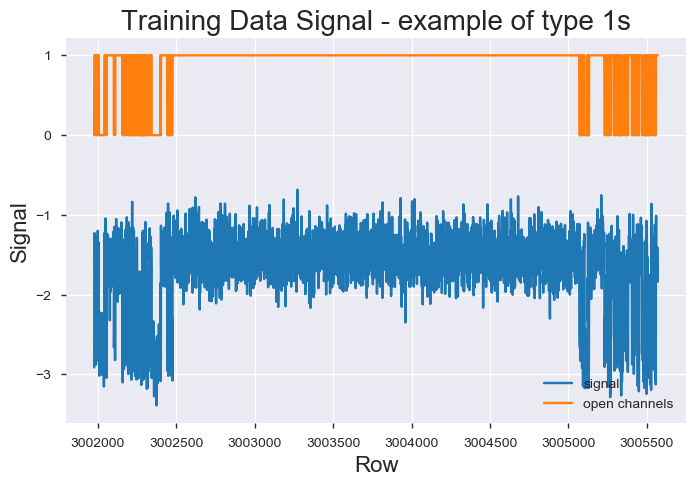

In [61]:
start = 3002476 -500
stop = 3005071 +500
plt.figure(figsize=(8,5)); res = 1
plt.plot(range(start, stop),train_k.signal[start:stop])
plt.plot(range(start, stop),train_k.open_channels[start:stop])
plt.xlabel('Row',size=16); plt.ylabel('Signal',size=16); 
plt.legend(('signal', 'open channels'), loc='lower right')
plt.title('Training Data Signal - example of type 1s',size=20)
plt.show()

We are trying to see which interval length is the threshold for 95% of the 1 open channel intervals count. Note that this is different from the cummulative number of timesteps in these intervals!

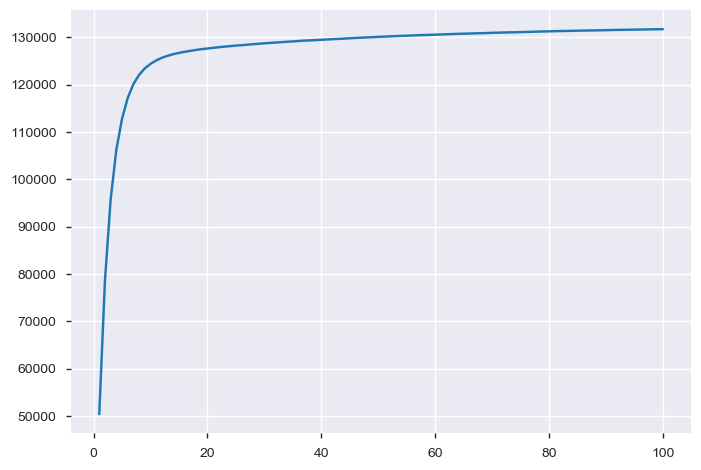

In [62]:
# elements are sorted by length, cumulative sum of their count
cum_count = np.cumsum(counts_elements)
axis_limit_low = 0
axis_limit_up = 100
plt.plot(unique_elements[axis_limit_low:axis_limit_up], cum_count[axis_limit_low:axis_limit_up])

In [63]:
# transfoorm in percentage
percent_cum_count = cum_count/counts_elements.sum()
open_channel_1_grouped = open_channel_1.groupby('length').count()
open_channel_1_grouped['cumulative_percent'] = percent_cum_count
open_channel_1_grouped.drop(['stop'], axis = 1, inplace= True)

In [64]:
# column name start is herited from groupby 
open_channel_1_grouped[open_channel_1_grouped.cumulative_percent > .99]

,start,cumulative_percent
length,,
110,12,0.990048
111,21,0.990206
112,25,0.990394
113,16,0.990514
114,11,0.990596
...,...,...
1999,1,0.999970
2065,1,0.999977
2173,1,0.999985


We see which interval lengths make up 95% of the interval count, but we want to see the weighted intervals (multiplying the count by the timesteps in the interval)

In [65]:
open_channel_1_grouped['total_timesteps_for_length'] = open_channel_1_grouped.index * open_channel_1_grouped.start

In [66]:
temp = np.cumsum(open_channel_1_grouped.total_timesteps_for_length)
open_channel_1_grouped['cumulative_percent_timesteps'] =  temp/open_channel_1_grouped.total_timesteps_for_length.sum()

In [67]:
open_channel_1_grouped[open_channel_1_grouped.cumulative_percent_timesteps > .95]

,start,cumulative_percent,total_timesteps_for_length,cumulative_percent_timesteps
length,,,,
1220,2,0.999767,2440,0.950912
1225,1,0.999775,1225,0.952155
1237,1,0.999782,1237,0.953409
1262,2,0.999797,2524,0.955970
1270,1,0.999805,1270,0.957258
1277,1,0.999812,1277,0.958553
1295,1,0.999820,1295,0.959867
1303,1,0.999827,1303,0.961188
1307,1,0.999835,1307,0.962514


In [68]:
open_channel_1_grouped.cumulative_percent_timesteps.describe()

count    561.000000
mean       0.721571
std        0.167264
min        0.051116
25%        0.636717
50%        0.748588
75%        0.836780
max        1.000000
Name: cumulative_percent_timesteps, dtype: float64

Now we want to add a feature to the original dataset which would be a categorical variable. It would capture if the event was short (up to 100 timesteps), medium (100 to 1000 timesteps) or long (over 1000 timesteps).

In [69]:
open_channel_1['duration'] = 0
open_channel_1['duration'][open_channel_1.length < 100] = 'short'
open_channel_1['duration'][open_channel_1.length >= 100] = 'medium'
open_channel_1['duration'][open_channel_1.length >= 1000] = 'long'

C:\Users\beren\anaconda3\envs\TensorFlow-GPU\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\beren\anaconda3\envs\TensorFlow-GPU\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [70]:
open_channel_1.tail()

,length,start,stop,duration
76191,1999,3143192,3145190,long
28224,2065,1459881,1461945,long
79525,2173,3209979,3212151,long
27226,2356,1435627,1437982,long
69516,2596,3002476,3005071,long


### 4. Which transitions are most common?
Are the events mostly changes of 1 open channel, or more?

In [71]:
temp = list(np.diff(train_k.open_channels))
temp.append(0)
train_k['open_channel_jump'] = temp

Text(0.5, 1.0, 'Distribution of events (changes in number of open channels)')

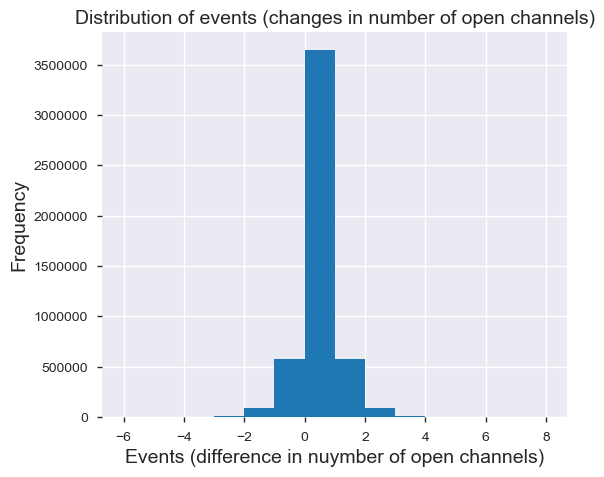

In [72]:
plt.figure(figsize=(6,5))

plt.hist(train_k.open_channel_jump, bins = 14)
plt.xlabel('Events (difference in nuymber of open channels)',size=14); plt.ylabel('Frequency',size=14); 
plt.title('Distribution of events (changes in number of open channels)',size=14)

(0, 20000)

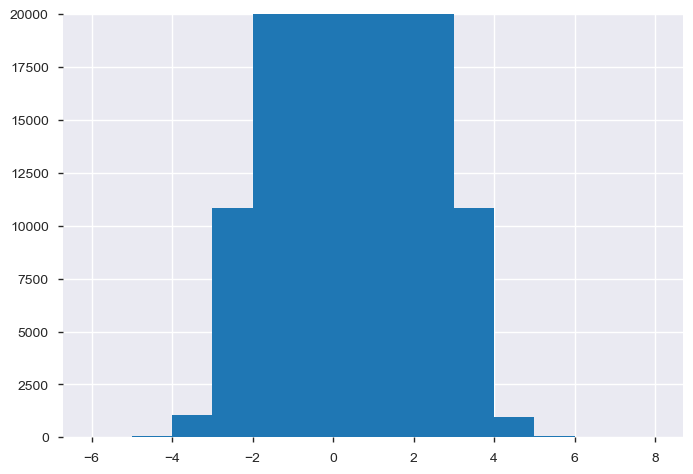

In [73]:
plt.hist(train_k.open_channel_jump, bins = 14)
plt.ylim((0, 20000))

In [74]:
train_k.groupby('open_channel_jump').count().time/50000

open_channel_jump
-6     0.00004
-5     0.00166
-4     0.02100
-3     0.21694
-2     1.74344
-1    11.58118
 0    72.86674
 1    11.58802
 2     1.74282
 3     0.21676
 4     0.01956
 5     0.00168
 6     0.00012
 7     0.00002
 8     0.00002
Name: time, dtype: float64